In [1]:
#!pip install transformers

In [2]:
#!pip install sentence-transformers

In [11]:
from sentence_transformers import SentenceTransformer, util
import numpy as np
import pandas as pd
import os
import xml.etree.ElementTree as ET
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import scipy
import numpy as np
import random
from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from transformers import Trainer, TrainingArguments
from datasets import load_metric
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


In [2]:
files = os.listdir("./From-ScisummNet-2019")
files

['P83-1020',
 'W02-1039',
 'P96-1021',
 'N06-1020',
 'C86-1016',
 'C92-2070',
 'D08-1082',
 'J01-2002',
 'C02-1114',
 'P85-1018',
 'P07-1032',
 'W00-1427',
 'C04-1111',
 'J97-1002',
 'W04-3237',
 'E87-1002',
 'P93-1041',
 'P90-1034',
 'P98-1035',
 'W02-0505',
 'P13-1045',
 'A00-2026',
 'J03-4004',
 'N03-1003',
 'C90-2067',
 'P84-1075',
 'W02-0908',
 'M95-1005',
 'P07-1028',
 'C00-2136',
 'P01-1019',
 'N10-1056',
 'J81-4003',
 'P93-1024',
 'C90-3030',
 'W02-2024',
 'P98-1013',
 'P03-1019',
 'P07-1065',
 'I05-3017',
 'P07-1056',
 'W03-0419',
 'W00-0726',
 'A00-2031',
 'D07-1090',
 'P02-1040',
 'P05-1011',
 'P02-1043',
 'A00-2009',
 'H94-1046',
 'C00-1044',
 'P11-1138',
 'C02-1011',
 'C96-1055',
 'N06-2015',
 'N03-1024',
 'P08-1101',
 'P96-1025',
 'P02-1019',
 'P09-1088',
 'C94-1042',
 'P99-1068',
 'N07-1018',
 'D07-1043',
 'J93-1007',
 'C08-1022',
 'P01-1030',
 'J01-2001',
 'N01-1008',
 'P05-3026',
 'P96-1024',
 'A00-2019',
 'E06-1042',
 'N06-1014',
 'P03-1011',
 'P11-1016',
 'C92-2082',

In [10]:
train_end = int(len(files)*0.7)
val_end = int(len(files)*0.1)+train_end
train_docs = files[0:train_end]
val_docs = files[train_end:val_end]
# test_docs = files[val_end:len(files)]

In [4]:
def preprocess(example_sent):
    stop_words = set(stopwords.words('english'))

    word_tokens = word_tokenize(example_sent.lower())

    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    filtered_sentence = [w for w in filtered_sentence if w.isalpha()]
#     print(filtered_sentence)
    new = " " 
    a = new.join(filtered_sentence)
    return a

    
def get_dataset(files):
    data_lis = []
    label_lis = []
#     tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    new_corpus_prev = None
    for z,f in enumerate(files):
        print("f",f)
        try:
            citants = pd.read_json("From-ScisummNet-2019/"+str(f)+"/citing_sentences.json")
            citants = citants[['citance_No','clean_text']]
            queries = list(citants['clean_text'])
            cite_no = list(citants.citance_No)
            tree = ET.parse("From-ScisummNet-2019/"+f+"/Reference_XML/"+f+".xml")
            root = tree.getroot()
            final1=[]
            final2=[]
            i = 0
            total = len(root)
            for a in root:
                for b in a:
                    final1.append(b.text)
                    if i == 0:
                        final2.append("Abstract")
                    if i == 1:
                        final2.append("Introduction")
                    elif i < total-2:
                        final2.append("Experiment/Discussion")
                    if i == total-2 or i == total-1:
                        final2.append("Results/Conclusion")
                    if i == total:
                        final2.append("Acknowledgment")
                i = i+1

            d={'col1':final1,'col2':final2}

            rp = pd.DataFrame(data=d)
            data_lis.extend(list(rp.col1))
            label_lis.extend(list(rp.col2))
            
        except Exception as e: print(e)
    return data_lis, label_lis
            
    
train_data, train_labels = get_dataset(train_docs)
val_data,val_labels = get_dataset(val_docs)
# test_data = get_dataset(test_docs)

f P83-1020
f W02-1039
f P96-1021
f N06-1020
f C86-1016
f C92-2070
f D08-1082
f J01-2002
f C02-1114
f P85-1018
f P07-1032
f W00-1427
f C04-1111
f J97-1002
f W04-3237
f E87-1002
All arrays must be of the same length
f P93-1041
f P90-1034
f P98-1035
f W02-0505
f P13-1045
f A00-2026
f J03-4004
f N03-1003
f C90-2067
f P84-1075
f W02-0908
f M95-1005
f P07-1028
f C00-2136
f P01-1019
f N10-1056
f J81-4003
f P93-1024
f C90-3030
f W02-2024
f P98-1013
f P03-1019
f P07-1065
f I05-3017
f P07-1056
f W03-0419
f W00-0726
f A00-2031
f D07-1090
f P02-1040
f P05-1011
f P02-1043
f A00-2009
f H94-1046
f C00-1044
f P11-1138
f C02-1011
f C96-1055
f N06-2015
f N03-1024
f P08-1101
f P96-1025
f P02-1019
f P09-1088
f C94-1042
f P99-1068
f N07-1018
f D07-1043
f J93-1007
f C08-1022
f P01-1030
f J01-2001
f N01-1008
f P05-3026
f P96-1024
f A00-2019
f E06-1042
f N06-1014
f P03-1011
f P11-1016
f C92-2082
f P02-1038
f J01-4004
f N09-1046
f D11-1125
f P94-1020
f W04-2609
f P09-1027
f H05-1073
f E06-1051
f P00-1065
f P04

In [5]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(train_labels)
train_labels = le.transform(train_labels)
val_labels = le.transform(val_labels)

In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model     = BertModel.from_pretrained('bert-large-uncased')
# model = BertForSequenceClassification.from_pretrained('bert-base-uncased')


In [ ]:
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encodings = tokenizer(train_data,return_tensors="pt",max_length=512,padding='max_length')
val_encodings = tokenizer(val_data,return_tensors="pt",max_length=512,padding='max_length')

In [ ]:
# # tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# train_encodings = tokenizer(train_data,return_tensors="pt",padding=True)
# val_encodings = tokenizer(val_data,return_tensors="pt",padding=True)

In [20]:
import torch

class IMDbDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = IMDbDataset(train_encodings, torch.from_numpy(train_labels))
val_dataset = IMDbDataset(val_encodings, torch.from_numpy(val_labels))
# test_dataset = IMDbDataset(test_encodings, test_labels)

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING']="1"

In [ ]:
min(train_labels), max(train_labels)

## Multi-class classifier

In [30]:

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=1,  # batch size per device during training
    per_device_eval_batch_size=1,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=1500,
)

# model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")
from transformers import AutoModelForSequenceClassification

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /home/avani.gupta/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABE

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

storing https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin in cache at /home/avani.gupta/.cache/huggingface/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
creating metadata file for /home/avani.gupta/.cache/huggingface/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache at /home/avani.gupta/.cache/huggingface/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.

Step,Training Loss
1500,1.225300


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
/home/avani.gupta/miniconda3/envs/new/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/home/avani.gupta/miniconda3/envs/new/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/p

TrainOutput(global_step=2382, training_loss=1.2230342989904754, metrics={'train_runtime': 360.9461, 'train_samples_per_second': 6.599, 'train_steps_per_second': 6.599, 'total_flos': 626736161028096.0, 'train_loss': 1.2230342989904754, 'epoch': 3.0})

In [31]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 832
  Batch size = 1
/home/avani.gupta/miniconda3/envs/new/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/home/avani.gupta/miniconda3/envs/new/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


{'eval_loss': 0.4331277012825012,
 'eval_runtime': 22.2682,
 'eval_samples_per_second': 37.363,
 'eval_steps_per_second': 37.363,
 'epoch': 3.0}

In [32]:
from torch.utils.data import DataLoader
val_dataloader = DataLoader(val_dataset, batch_size=8)

In [38]:
torch.save(model,"task1b_bert.pth")

In [99]:

# acc = load_metric("accuracy")

# f1_score = load_metric("f1")
model.eval()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
pred_lis = []
gt_lis = []
for batch in val_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    pred_lis.extend(predictions.cpu().numpy())
    gt_lis.extend(batch["labels"].cpu().numpy())
    

#     metric.add_batch(predictions=predictions, references=batch["labels"])
# metric.compute()

/home/avani.gupta/miniconda3/envs/new/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/home/avani.gupta/miniconda3/envs/new/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


In [117]:
val_labels.shape

(14664,)

In [116]:
len(gt_lis)

832

In [12]:
def calc_metrics(pred_lis, gt_lis):
    acc = accuracy_score(pred_lis, gt_lis)
    recall = recall_score(pred_lis, gt_lis,average='micro')
    prec = precision_score(pred_lis, gt_lis,average='micro')
    f1 = f1_score(pred_lis, gt_lis,average='micro')
    print("metrics obtained in test: accuracy {} recall {}, precision {}, f1-score {}".format(acc,recall,prec,f1))
    
def get_integer_mapping(le):
    '''
    Return a dict mapping labels to their integer values
    from an SKlearn LabelEncoder
    le = a fitted SKlearn LabelEncoder
    '''
    res = {}
    for cl in le.classes_:
        res.update({le.transform([cl])[0]:cl})

    return res

In [ ]:
calc_metrics(pred_lis, gt_lis)

In [126]:
gt_lis = np.array(gt_lis)
pred_lis = np.array(pred_lis)

In [15]:

mapping = get_integer_mapping(le)
mapping

{0: 'Experiment/Discussion', 1: 'Introduction', 2: 'Results/Conclusion'}

In [131]:
#class-wise metrics
for cl in mapping:
    print("for class: ",mapping[cl])
    ind = np.where(gt_lis==cl)
    small_pred = pred_lis[ind]
#     print(small_pred, gt_lis[ind])
    calc_metrics(small_pred, gt_lis[ind])


for class:  Experiment/Discussion
metrics obtained in test: accuracy 1.0 recall 1.0, precision 1.0, f1-score 1.0
for class:  Introduction
metrics obtained in test: accuracy 0.0 recall 0.0, precision 0.0, f1-score 0.0
for class:  Results/Conclusion
metrics obtained in test: accuracy 0.0 recall 0.0, precision 0.0, f1-score 0.0


In [93]:
batch["labels"]

tensor([2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')

This is due to class-imbalance

## Classifiers Imbalance

In [16]:
from collections import Counter
def get_distribution(labels, typ = "dataset"):
    lb = list(Counter(labels).keys()) # equals to list(set(words))
    count = list(Counter(labels).values()) # counts the elements' frequency
    lb_map = []
    for l in lb:
        lb_map.append(mapping[l])

    from matplotlib import pyplot as plt
    import numpy as np

    # Creating plot
    fig = plt.figure(figsize =(10, 7))
    plt.pie(count, labels = lb_map)

    # show plot
    plt.title("distribution in "+str(typ))
    plt.show()

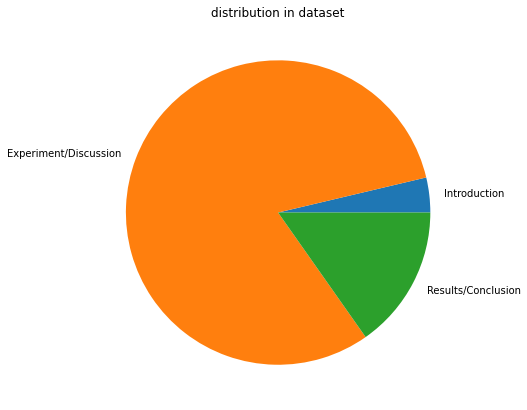

In [17]:
get_distribution(np.concatenate((train_labels,val_labels)))

## Classifiers for each class

In [18]:
val_labels

array([1, 1, 1, ..., 2, 2, 2])

In [23]:
from transformers import Trainer, TrainingArguments

# model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")
from transformers import AutoModelForSequenceClassification

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=1,  # batch size per device during training
    per_device_eval_batch_size=1,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='/ssd_scratch/cvit/logs',            # directory for storing logs
    logging_steps=1500,
)


for cl in mapping:
    print("for class: ",mapping[cl])
    train_ind = np.where(train_labels==cl)[0].astype(int)
    val_ind = np.where(val_labels==cl)[0].astype(int)
    
    train_data = np.array(train_data)
    val_data = np.array(val_data)
    
    train_encodings = tokenizer(list(train_data[train_ind]),return_tensors="pt",max_length=512,padding='max_length',truncation=True)
    val_encodings = tokenizer(list(val_data[val_ind]),return_tensors="pt",max_length=512,padding='max_length',truncation=True)
    train_dataset = IMDbDataset(train_encodings, torch.from_numpy(train_labels[train_ind]))
    val_dataset = IMDbDataset(val_encodings, torch.from_numpy(val_labels[val_ind]))    
    model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
    
    
    trainer = Trainer(
        model=model,                         # the instantiated 🤗 Transformers model to be trained
        args=training_args,                  # training arguments, defined above
        train_dataset=train_dataset,         # training dataset
        eval_dataset=val_dataset             # evaluation dataset
    )

    trainer.train()
    # eval
    val_dataloader = DataLoader(val_dataset, batch_size=8)
    model.eval()
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    pred_lis = []
    gt_lis = []
    for batch in val_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        pred_lis.extend(predictions.cpu().numpy())
        gt_lis.extend(batch["labels"].cpu().numpy())
    
    calc_metrics(pred_lis, gt_lis)


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


for class:  Experiment/Discussion


https://huggingface.co/bert-base-uncased/resolve/main/config.json not found in cache or force_download set to True, downloading to /home/avani.gupta/.cache/huggingface/transformers/tmpb9l234l3


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

storing https://huggingface.co/bert-base-uncased/resolve/main/config.json in cache at /home/avani.gupta/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
creating metadata file for /home/avani.gupta/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /home/avani.gupta/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidde

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

storing https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin in cache at /home/avani.gupta/.cache/huggingface/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
creating metadata file for /home/avani.gupta/.cache/huggingface/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache at /home/avani.gupta/.cache/huggingface/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.Lay

Step,Training Loss


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
/home/avani.gupta/miniconda3/envs/new/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/home/avani.gupta/miniconda3/envs/new/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


KeyboardInterrupt: 